## Resource-Constrained Project Scheduling Problem with Alternative Subgraphs

This notebook demonstrates how to model and solve the Resource-Constrained Project Scheduling Problem with Alternative Process Plan using Constraint Programming with IBM’s CP Optimizer via the [`docplex.cp`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API. CP formulation of the problem is inspired by [Jakub Charvat bachelor thesis](https://dspace.cvut.cz/handle/10467/123532).

### Problem Definition

The Resource-Constrained Project Scheduling Problem with Alternative Subgraphs (RCPSP-AS) models a project as a directed acyclic graph $G=(N,A)$, where $N=\{1, \dots, n\}$ is the set of non-preemptive, topologically ordered activities $i, j$, and $A \subset N \times N$ defines the end-start precedence constraints $(i,j)$. Each activity $i$ has a predetermined duration $d_i$ and demands $r_{i,v}$ from a set of renewable resources $R$, where each resource $v \in R$ has a limited capacity $a_v$. The problem's core feature is a set of alternative subgraphs $L$, where each $l \in L$ (or $l' \in L$) is defined by a principal activity $p_l$ and a terminal activity $t_l$. Each subgraph $l$ contains multiple alternative branches $K_{p_l}$, and a branch $k \in K_{p_l}$ (or $k' \in K_{p_l}$) is a subset of activities $N_{b_k} \subset N^a$ starting from a unique branching activity $b_k$, such that $b_k \in N_{b_k} \wedge p_l \notin N_{b_k} \wedge t_l \notin N_{b_k}$ holds. This structure partitions $N$ into alternative activities $N^a = \bigcup N_{b_k}$ and fixed activities $N^f = N \setminus N^a$. Extensions include nested subgraphs and linked branches, the latter defined by a parameter $\kappa_{i,j}=1$ if an activity $i \in N_{b_k}$ is linked to $j \in N_{b_{k'}}$ (where $k \neq k'$).

### CP Formulation

$$
\begin{aligned}
\min \quad
& \mathrm{endOf}(\mathrm{x}_{n-1})
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \mathrm{presenceOf}(\mathrm{x}_{0}) = 1,
\qquad &\qquad & \text{(2)} \\[1mm]
& \mathrm{ifThen}\!\left(\mathrm{presenceOf}(\mathrm{x}_i) \wedge \mathrm{presenceOf}(\mathrm{x}_j),\; \mathrm{endOf}(\mathrm{x}_i) \le \mathrm{startOf}(\mathrm{x}_j)\right),
\qquad & \forall (i,j)\in A
\quad & \text{(3)} \\[1mm]
& \sum_{k \in K_{p_l}} \mathrm{presenceOf}(\mathrm{x}_{k}) = \mathrm{presenceOf}(\mathrm{x}_{p_l}),
\qquad & \forall l \in L
\quad & \text{(4)} \\[1mm]
& \mathrm{presenceOf}(\mathrm{x}_i) = \left( \sum_{b_k \in M(B_i^{id})} \mathrm{presenceOf}(\mathrm{x}_{b_k}) > 0 \right),
\qquad & \forall i \in N \setminus \{0\}
\quad & \text{(5)} \\[1mm]
& \sum_{i \in N} \mathrm{pulse}(\mathrm{x}_i, r_{i,v}) \le a_v,
\qquad & \forall v \in R
\quad & \text{(6)} \\[1mm]
& \text{interval } \mathrm{x}_i\ \text{optional, size}=d_i,
\qquad & \forall i \in N
\quad & \text{(7)}
\end{aligned}
$$

Objective:

* **(1)** Minimize the makespan $C_{\max}$, defined as the end time of the sink activity $n-1$.

Modeling Constraints:

* **(2)** Ensures the source activity (activity 0) is always selected.
* **(3)** Enforces all precedence relations $(i,j) \in A$. The condition ($\mathrm{endOf}(\mathrm{x}_i) \le \mathrm{startOf}(\mathrm{x}_j)$) is enforced conditionally, only if *both* activities $i$ and $j$ are present.
* **(4)** Enforces subgraph branch selection. For each alternative subgraph $l$, the sum of the presence of its branching activities ($k \in K_{p_l}$) must equal the presence of its principal activity $p_l$.
* **(5)** Unified Activity Selection: Enforces that any activity $i \in N \setminus \{0\}$ is present if and only if at least one of the branches it belongs to is selected. This single rule covers both alternative activities (where a choice is made) and fixed activities (where presence is guaranteed by the dummy branch tied to the source $x_0$).
* **(6)** Enforces renewable resource limits. The `pulse` function models the resource demand $r_{i,v}$ during the execution of a present interval. The sum of all pulses on a resource $v$ must never exceed its capacity $a_v$.

Variables:

* **(7)** $\mathrm{x}_i$: An optional interval variable for each activity $i \in N$ with a fixed duration $d_i$.

#### Symbols and Notation

| Symbol / Function | Meaning | `docplex.cp` Reference | OptalCP Reference |
| :--- | :--- | :--- | :--- |
| $N$ | Set of activities, indexed $0..n-1$ | — | — |
| $A$ | Set of precedence constraints $(i,j)$ | — | — |
| $L$ | Set of alternative subgraphs | — | — |
| $R$ | Set of renewable resources | — | — |
| $N^a, N^f$ | Sets of alternative and fixed activities | — | — |
| $d_i$ | Predetermined duration of activity $i$ | — | — |
| $r_{i,v}$ | Demand of activity $i$ for resource $v$ | — | — |
| $a_v$ | Capacity of renewable resource $v$ | — | — |
| $p_l$ | Principal activity of subgraph $l$ | — | — |
| $K_{p_l}$ | Set of successors (branching activities) of $p_l$ | — | — |
| $B_i^{id}$ | Set of branch IDs activity $i$ belongs to | — | — |
| $M$ | Map from branch ID $B_i^{id}$ to branching activity | — | — |
| $\mathrm{x}_i$ | Optional interval variable for activity $i$ | [interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.interval_var) | [interval_var](https://optalcp.com/docs/api/classes/IntervalVar) |
| $\mathrm{presenceOf}(\mathrm{x}_i)$ | $1$ if interval $\text{x}_{i}$ is present, else $0$ | [presence_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.presence_of) | [interval_var.presence](https://optalcp.com/docs/api/classes/IntervalVar#presence) |
| $\mathrm{endOf}(\dots)$ | End time of an interval | [end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) | [interval_var.end](https://optalcp.com/docs/api/classes/IntervalVar#end) |
| $\mathrm{startOf}(\dots)$ | Start time of an interval | [start_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.start_of) | [interval_var.start](https://optalcp.com/docs/api/classes/IntervalVar#start) |
| $\mathrm{ifThen}(\dots)$ | Logical implication constraint | [if_then](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.if_then) | [bool_expr.implies](https://optalcp.com/docs/api/classes/BoolExpr#implies) |
| $\mathrm{pulse}(\dots)$ | Time-varying resource usage | [pulse](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.pulse) | [interval_var.pulse](https://optalcp.com/docs/api/classes/IntervalVar#pulse) |

### Data Import & Parsing

In [14]:
%pip install -q docplex graphviz ortools
from io import StringIO
import graphviz as gv

# Using ascp package from Charvat's bachelor thesis
from ascp.load_instance import load_instance
from ascp.instance import AslibInstance, Subgraph
from ascp.graphviz import show_instance
from ascp.solver import Solution, SolvedActivity

Note: you may need to restart the kernel to use updated packages.


#### Reading the data file

In [15]:
instance = load_instance('../../data/rcpspas/robot-example/robot-example_a.rcp')

# create a dictionary to map activity IDs (0-based) to their objects
act_dict = {act.id: act for act in instance.activities}

# build branching activity map links branch_id to branching_activity_id
M = {
    branch_id: b_k_act_id
    for sub in instance.subgraphs if sub.principal_activity in act_dict
    for b_k_act_id in act_dict[sub.principal_activity].successors if b_k_act_id in act_dict
    for branch_id in act_dict[b_k_act_id].branches.intersection(sub.branches) if branch_id != 0
}

# manually add the dummy branch k* (ID 0) mapping to its branching activity (ID 0)
M[0] = 0

#### Visualize the instance structure

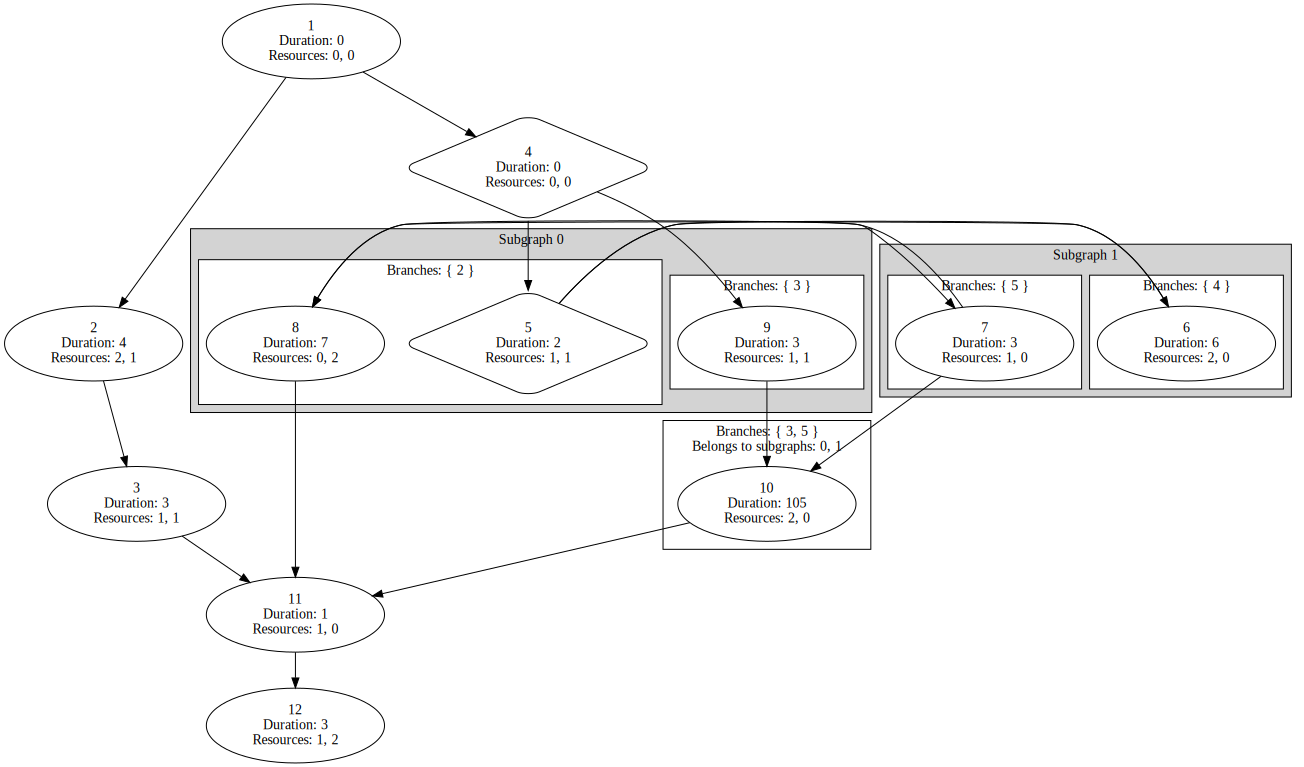

In [16]:
dot_output = StringIO()
show_instance(instance, file=dot_output)
dot_string = dot_output.getvalue()

graph = gv.Source(dot_string)
display(graph)

### IBM CPO DOcplex Implementation

#### Imports

In [17]:
from docplex.cp.model import CpoModel

#### Create model and variables

In [18]:
# Create a CP Optimizer model
mdl = CpoModel(name=instance.name)

# (4) create optional interval variable for each activity i with a fixed duration d_i
x = {i: mdl.interval_var(
    name=f"T_{i}", optional=True, size=act.duration) for i, act in act_dict.items()}

#### Add constraints and define objective

In [19]:
# (1) Minimize the makespan (end time of the single sink activity)
mdl.add(mdl.minimize(mdl.end_of(x[len(instance.activities) - 1])))

# (2) Source activity is present
mdl.add(mdl.presence_of(x[0]) == 1)

# (3) Enforces all precedence relations
mdl.add(mdl.if_then(mdl.presence_of(x[act.id]) & mdl.presence_of(x[j]),
                    mdl.end_of(x[act.id]) <= mdl.start_of(x[j]))
        for act in instance.activities for j in act.successors if j in x)

# (4) Enforces subgraph branch selection
mdl.add(mdl.sum(mdl.presence_of(x[s])
                for s in act_dict[sub.principal_activity].successors if s in x) ==
        mdl.presence_of(x[sub.principal_activity])
        for sub in instance.subgraphs if sub.principal_activity in act_dict)

# (5) Enforces activity selection
mdl.add(mdl.presence_of(x[i]) == (mdl.sum(mdl.presence_of(x[M[b_id]])
                                          for b_id in act.branches if b_id in M) > 0)
        for i, act in act_dict.items() if i != 0)

# (6) Enforces renewable resource limits
mdl.add(mdl.sum(mdl.pulse(x[act.id], act.requirements[v])
                for act in instance.activities if act.requirements[v] > 0) <= capacity
        for v, capacity in enumerate(instance.resources) if capacity > 0)

#### Solve the model

In [20]:
print('Solving model...')
solution = mdl.solve(FailLimit=100000,TimeLimit=10, LogVerbosity='Quiet')
print('Solution: ')
solution.print_solution()

Solving model...
Solution: 
-------------------------------------------------------------------------------
Model constraints: 31, variables: integer: 0, interval: 12, sequence: 0
Solve status: Optimal
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.1 sec
-------------------------------------------------------------------------------
Objective values: (21,), bounds: (21,), gaps: (0,)
Variables:
   T_0 = IntervalVarValue(start=0, end=0, size=0)
   T_1 = IntervalVarValue(start=0, end=4, size=4)
   T_2 = IntervalVarValue(start=4, end=7, size=3)
   T_3 = IntervalVarValue(start=0, end=0, size=0)
   T_4 = IntervalVarValue(start=0, end=2, size=2)
   T_5 = IntervalVarValue(start=4, end=10, size=6)
   T_6 = ()
   T_7 = IntervalVarValue(start=10, end=17, size=7)
   T_8 = ()
   T_9 = ()
   T_10 = IntervalVarValue(start=17, end=18, size=1)
   T_11 = IntervalVarValue(start=18, end=21, size=3)


#### Resource unit assignment

In [21]:
# TODO

#### Visualisation

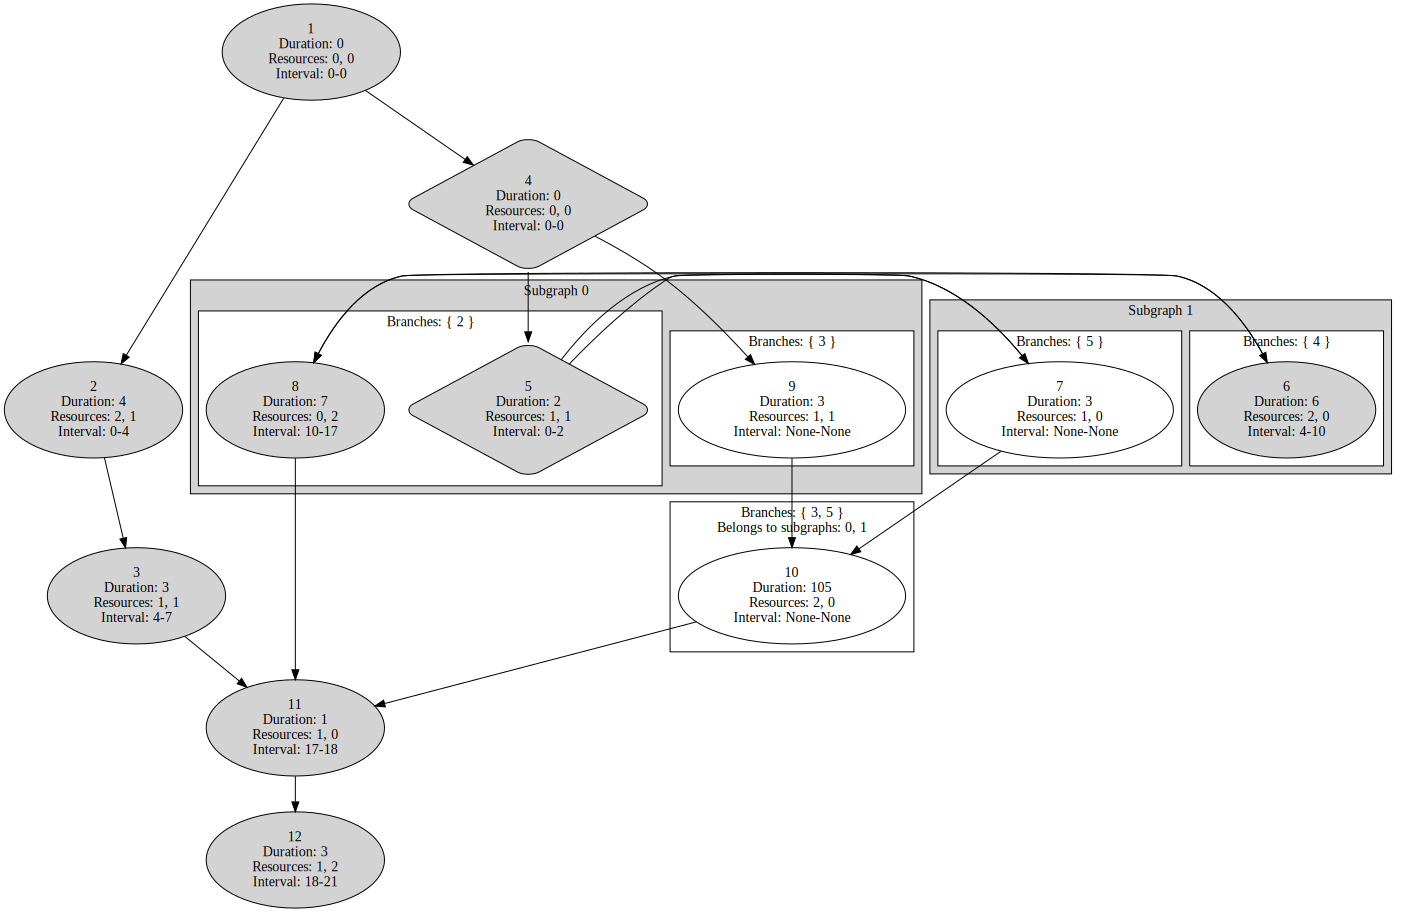

In [22]:
solved_activities = [
    SolvedActivity(
        id=act.id, is_scheduled=True, start_time=sol.get_start(),
        end_time=sol.get_end(), resource_requirements=act.requirements
    ) if sol and sol.is_present() else
    SolvedActivity(
        id=act.id, is_scheduled=False, resource_requirements=act.requirements
    )
    for act in instance.activities
    for sol in [solution.get_var_solution(x[act.id])]
]

cplex_solution = Solution(
    objective=int(solution.get_objective_values()[0]),
    activities=solved_activities
)

dot_output = StringIO()
show_instance(instance, cplex_solution, file=dot_output)
dot_string = dot_output.getvalue()
display(gv.Source(dot_string))

### OptalCP Implementation

#### Imports

In [23]:
import optalcp as cp

#### Create model and variables

In [24]:
# Create an OptalCP model
mdl_ocp = cp.Model()

# (7) Create optional interval variable for each activity i with a fixed duration d_i
x_ocp = {i: mdl_ocp.interval_var(
    name=f"T_{i}", optional=True, length=act.duration) for i, act in act_dict.items()}

#### Add constraints and define objective

In [25]:
# (1) Minimize makespan
mdl_ocp.minimize(x_ocp[len(instance.activities) - 1].end())

# (2) Source activity is present
mdl_ocp.constraint(x_ocp[0].presence() == 1)

# (3) Precedence relations
for act in instance.activities:
    for j in act.successors:
        if j in x_ocp:
            mdl_ocp.constraint((x_ocp[act.id].presence() & x_ocp[j].presence()).implies(
                x_ocp[act.id].end() <= x_ocp[j].start()))

# (4) Subgraph branch selection
for sub in instance.subgraphs:
    if sub.principal_activity in act_dict:
        branches = [s for s in act_dict[sub.principal_activity].successors if s in x_ocp]
        if branches:
            mdl_ocp.constraint(sum(x_ocp[s].presence() for s in branches) == 
                             x_ocp[sub.principal_activity].presence())

# (5) Activity selection
for i, act in act_dict.items():
    if i != 0:
        branch_presences = [x_ocp[M[b_id]].presence() for b_id in act.branches if b_id in M]
        if branch_presences:
            mdl_ocp.constraint(x_ocp[i].presence() == (sum(branch_presences) > 0))

# (6) Resource limits
for v, capacity in enumerate(instance.resources):
    if capacity > 0:
        pulses = [x_ocp[act.id].pulse(height=act.requirements[v])
                 for act in instance.activities if act.requirements[v] > 0]
        if pulses:
            mdl_ocp.constraint(mdl_ocp.sum(pulses) <= capacity)

#### Solve the model

In [26]:
print('Solving OptalCP model...')
result_ocp = cp.solve(mdl_ocp, cp.Parameters(timeLimit=30))
print('OptalCP Solution:')
print(result_ocp)

Solving OptalCP model...
--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   TimeLimit = 30 seconds
Input:
   0 integer variables, 12 interval variables, 31 constraints, 27.4kB
   00:00 Presolving..
Presolved:
   0 integer variables, 12 interval variables, 25 constraints, 28.7kB
   00:00 Starting the search using 12 workers (physical cores count).
--------------------------------------------------------------------------------
   00:00 Lower bound 11 Worker 0
   00:00 Solution 114 Worker 0: LNS
   00:00 Solution 21 Worker 0: LNS
   00:00 Lower bound 21 Worker 0: Optimality proof
   00:00 Worker 0: The current best solution is optimal.
-----------------------------------

## Aditional Resources

- [ASLIB dataset](https://www.projectmanagement.ugent.be/research/data)
- [Jakub Charvat bachelor thesis](https://dspace.cvut.cz/handle/10467/123532)